# Deep Learning: Convolutional Neural Networks (CNN)

**Course:** AI in AEC (Architecture, Engineering, and Construction) Summer School, ETH Zurich.

**Authors**: Sophia Kuhn (sophia.kuhn@ibk.baug.ethz.ch) and Diana Steffen



### Notebook Content
- [1. Network Layout](#Layout)
- [2. Data Set](#Dataset)
    - Import
    - Preparation
- [3. Model](#Model)
    - Initialisation
    - Training
    - Evaluation
    - Test on Example
- [4. (bonus) Fine Tuning A Pretrained Model](#Finetuning)

### Package Installation

The following packages are needed and should be installed.

You can install them by running: <em>pip install pillow matplotlib numpy tensorflow</em>

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image

## <a name="Layout"></a>1. Network Layout

<!-- ![CNN Schema](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*vkQ0hXDaQv57sALXAJquxA.jpeg)  -->

Example image for a multi-class classification network. This is taken from a nice article that explaines CNNs [[1]](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).


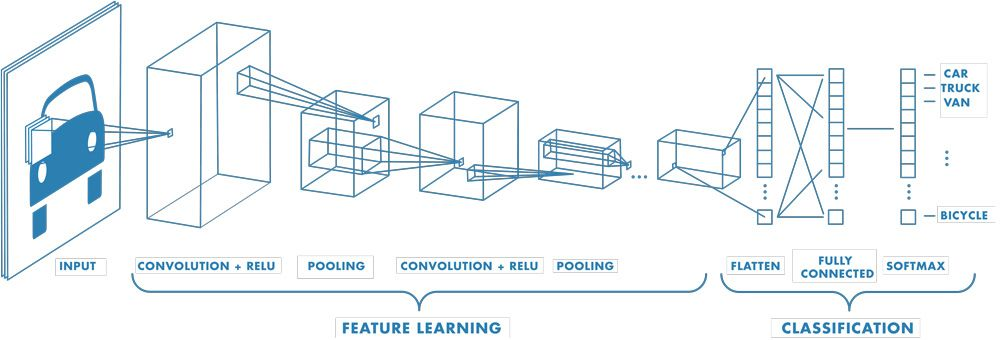

In [2]:
from IPython.display import Image as Img
Img("cnn_image.jpeg")

## <a name="Dataset"></a> 2. Dataset

In this tutorial we will work with the *Concrete Crack Images for Classification* dataset available online [2]. If you cannot access them via the provided folder, you can download them from [Kaggle](https://www.kaggle.com/datasets/arunrk7/surface-crack-detection) or [Mendeley Data](https://data.mendeley.com/datasets/5y9wdsg2zt/2).
The images are split into a 'Positive' and a 'Negative' folder, where 'Positive' images contain cracks and 'Negative' images do not.
Copy the downloaded archive into the folder your notebook is in.

### Import
We import the images using the PIL package and restrict the import to 100 images, to show some examples:

In [3]:
def import_images_from_folder(folder, limit=None):
    images = []
    for filename in glob.iglob(folder + '/*.jpg'):
        img = Image.open(filename)
        images.append(img)
        if limit:
            if len(images)>limit:
                break
    return images

In [4]:
cracks_pos = import_images_from_folder('archive_small/Positive', 100)
cracks_neg = import_images_from_folder('archive_small/Negative', 100)

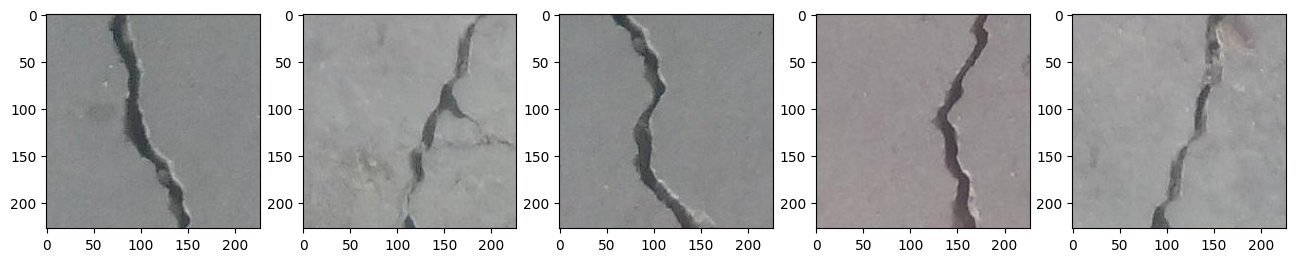

In [5]:
fig, axs = plt.subplots(1,5, figsize=(16,8))
for i in range(5):
    axs[i].imshow(cracks_pos[i]) 

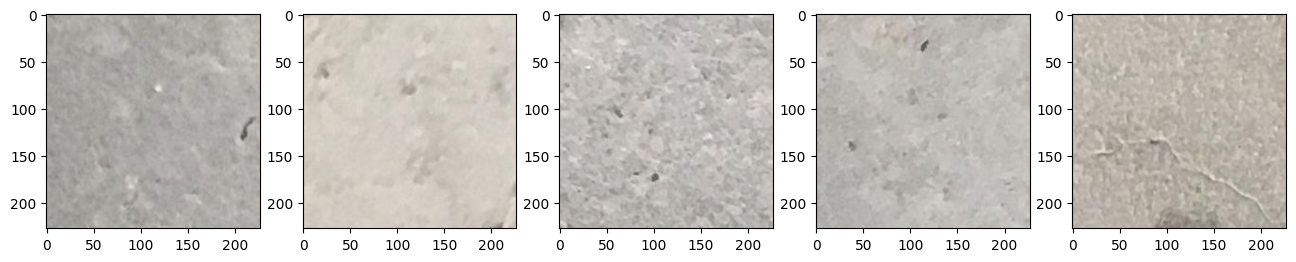

In [6]:
fig, axs = plt.subplots(1,5, figsize=(16,8))
for i in range(5):
    axs[i].imshow(cracks_neg[i]) 

A single image has 227 x 227 pixels with RGB channel:

In [7]:
image_shape = np.array(cracks_neg[0]).shape
print(image_shape)

(227, 227, 3)


### Preparation

As it takes a long time to train our model on the whole data set, we will extract and use a small subset of the data set for this exercise. You can change the folder name in "data_dir" to run the code on the whole data set.

In [8]:
# if the model training runs too slow, we can also create a sample of the data by running this cell
parent_pathname = 'archive_small'
if not os.path.exists(parent_pathname):
    # create directory first
    os.mkdir(parent_pathname)
    print('created new directory', parent_pathname)
    
new_positive = os.path.join(parent_pathname, 'Positive')
if not os.path.exists(new_positive):
    # create directory first
    os.mkdir(new_positive)
    print('created new directory', new_positive)
    
limit = 100

count = 0
for filename in glob.iglob('archive/Positive' + '/*.jpg'):
    img = Image.open(filename)
    filename = os.path.join(new_positive, filename.split("\\")[1])
    # when using mac try: filename.split("/")[2]
    img.save(filename)
    count += 1
    if count>limit:
        break
            
new_negative = os.path.join(parent_pathname, 'Negative')
if not os.path.exists(new_negative):
    # create directory first
    os.mkdir(new_negative)
    print('created new directory', new_negative)

count = 0
for filename in glob.iglob('archive/Negative' + '/*.jpg'):
    img = Image.open(filename)
    filename = os.path.join(new_negative, filename.split('\\')[1])
    # when using mac try: filename.split("/")[2]
    img.save(filename)
    count += 1
    if count>limit:
        break

In [9]:
# data_dir = 'archive' 
# run the above line if you want to train on the whole data set
# Note: you would need to download the entire data set first.
data_dir = 'archive_small'

We need to split the data into train and test sets. We will use the Keras [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) to achieve this. The data is split into 20% for model validation, and 80% for model training. [3]

In [10]:
#train test split
train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=22,
  image_size=(image_shape[0], image_shape[1]),
  batch_size=32)

Found 202 files belonging to 2 classes.
Using 162 files for training.


In [11]:
validation = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=22,
  image_size=(image_shape[0], image_shape[1]),
  batch_size=32)

Found 202 files belonging to 2 classes.
Using 40 files for validation.


The Keras functionality automatically detects the two sub-folders 'Positive' and 'Negative', and uses their names as classes for the images.

In [12]:
class_names = train.class_names
print(class_names)

['Negative', 'Positive']


As seen above, the images are stored in RGB channel, which means that its values range in [0, 255]. \
Ideally, values should be small which is why we scale all pixel values into the range of [0,1].

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_norm = train.map(lambda x, y: (normalization_layer(x), y))
val_norm = validation.map(lambda x, y: (normalization_layer(x), y))


image_batch, labels_batch = next(iter(train_norm))
first_image = image_batch[0]
print('example first image:')
print('smallest pixel value:', np.min(first_image), 'highest pixel value:', np.max(first_image))
print(labels_batch)

example first image:
smallest pixel value: 0.0 highest pixel value: 0.7137255
tf.Tensor([1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0], shape=(32,), dtype=int32)


## <a name="Model"></a>3. Model

Now we want to build a Convolutional Neural Network which is able to distinguish images with a crack from images without a crack. We will use Tensorflow to achieve this [4].

### Inititalisation

We define the number of classes to be 2, since we know that the dataset contains two kinds of images.

We implement a [**sequential**](https://www.tensorflow.org/guide/keras/sequential_model) model, where we stack multiple layers after each other to build the model.\
A [**convolutional layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) creates a convolutional kernel and applies it to the layer input. 
<img src="https://cdn-images-1.medium.com/max/1600/1*p-_47puSuVNmRJnOXYPQCg.png" width="400" height="400" />

We use the 'RELU' activation function to transform the convolutional output to the 'activation' of the node. The **RELU** activation reproduces its input if it is positive, but returns 0 if the input is negative. This activation function therefore inactivates negative nodes:
$$RELU(x)=max(0,x)$$


The [**MaxPooling layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) is responsible for downsampling the output of the convolutional layer by shifting a smaller window over the image, and taking the maximum value in the window for each channel. [5]\
<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" width="400" height="400" />

A [**Flatten layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) flattens its multi-dimensional input into a flat vector.\
The [**Dense layers**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) introduce a new set of neurons, here 128 with a relu activation and 2 (for the number of classes), to get to the desired output dimension.

The layout is similar to the example network image we saw at the beginning of the tutorial, except for the missing softmax layer at the end. Since we are doing binary classification, such a layer is not needed.

In [14]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, 8, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 12, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 12, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [15]:
# Note: a list of all layer types of NNs in Keras can be found here: 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers

We compile the model using the [ADAM](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer.

In [16]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Training
We train the model for a small amount of epochs and monitor its accuracy.

In [17]:
epochs = 10

In [18]:
history = model.fit(
  train_norm,
  validation_data=val_norm,
  epochs=epochs,
)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4881 - loss: 0.6961 - val_accuracy: 0.4000 - val_loss: 0.6942
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5338 - loss: 0.6831 - val_accuracy: 0.4000 - val_loss: 0.7045
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4534 - loss: 0.6935 - val_accuracy: 0.4000 - val_loss: 0.6923
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5531 - loss: 0.6808 - val_accuracy: 0.4000 - val_loss: 0.6991
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5231 - loss: 0.6760 - val_accuracy: 0.4000 - val_loss: 0.6919
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6134 - loss: 0.6767 - val_accuracy: 0.4000 - val_loss: 0.6932
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5389 - loss: 0.6721 - val_accuracy: 0.4000 - val_loss: 0.7132
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5017 - loss: 0.6764 - val_accuracy: 0.4000 - val_loss: 0.7090
Epoch 9/

### Evaluation
In the end, we want to evaluate the performance of our model on the validation dataset, to prevent overfitting. We can display the development of the model's accuracy on the training and on the validation data using the model's history:

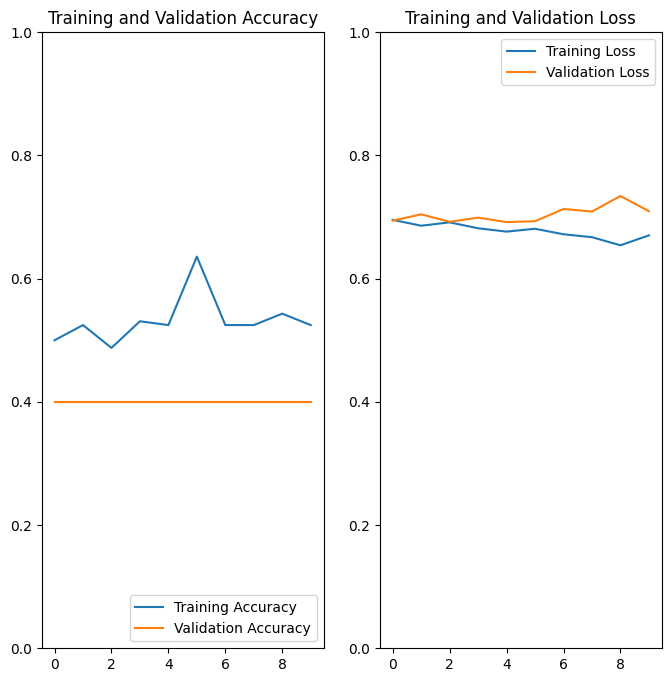

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim(0,1)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After 10 epochs the validation curve is close to the training curve. This indicates that our model is not too much overfitting to the training data.

After 50 epochs we see that the model overfits on the training data. We can see this by the increase of validation loss.


The figure below shows an example of a classification model that strongly overfits the training data. 
The graph shows that after many epochs the model can overfit to the training data. This is the case if the model perfroms significantly better on the training data than on the validation data.

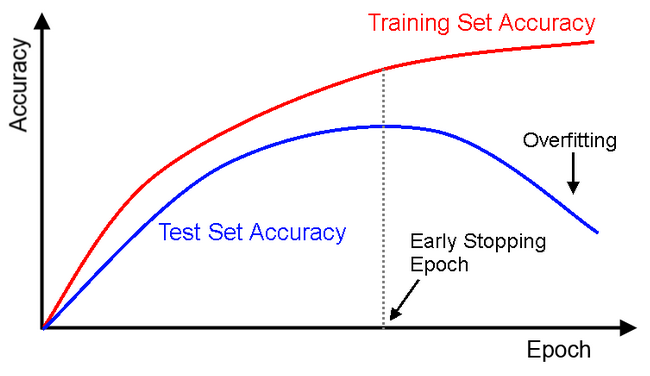

In [20]:
from IPython.display import Image as Img
Img("OverfittingDetection.png")
# Image Source: [6]

### Test on Example

With the trained model, we can try to upload and classify an image we took ourselves!

In [21]:
own_image = import_images_from_folder('own_image', 1)[0]

In [22]:
# resize the image
print(np.array(own_image).shape)
print(own_image.size)

oimg = own_image.resize((227, 227))

print(np.array(oimg).shape)
print(oimg.size)

(3024, 4032, 3)
(4032, 3024)
(227, 227, 3)
(227, 227)


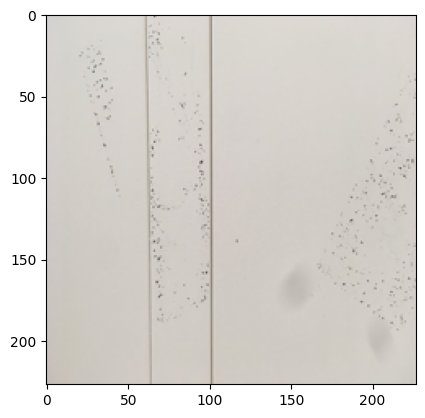

In [23]:
plt.imshow(oimg) 

In [24]:
img_array = tf.keras.utils.img_to_array(oimg)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
This image most likely belongs to Negative with a 100.00 percent confidence.


## 4. <a name="Finetuning"></a>(Bonus) Fine Tuning A Pretrained Model

There exist plenty of pre-trained CNN's online. We can try to skip the expensive training phase by taking such a model pre-trained on some generic images and adding some final layers suited for our data.

Resources: 

https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29 \
https://keras.io/guides/transfer_learning/ \
https://cv-tricks.com/keras/fine-tuning-tensorflow/

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(include_top=False, weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', input_shape=image_shape)
# freeze the base_model layers since we do not want to train them initially
base_model.trainable = False

ft_model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

# in the summary we can see that not all parameters are trainable anymore
ft_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,338 (68.38 MB)

 Trainable params: 3,211,650 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
ft_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [27]:
# train the model only on the custom layers
ft_epochs = 5
ft_history = ft_model.fit(
  train_norm,
  validation_data=val_norm,
  epochs=ft_epochs,
)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5895 - loss: 0.8237 - val_accuracy: 0.6500 - val_loss: 0.3955
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.7823 - loss: 0.4012 - val_accuracy: 0.7250 - val_loss: 0.4303
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.9012 - loss: 0.2466 - val_accuracy: 1.0000 - val_loss: 0.1002
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.9925 - loss: 0.0909 - val_accuracy: 1.0000 - val_loss: 0.0672
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.9883 - loss: 0.0540 - val_accuracy: 0.9750 - val_loss: 0.0923


In [28]:
# unfreeze all layers and fine-tune the entire model once
base_model.trainable = True
# we need to re-compile the model to apply the change
ft_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

ft_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,338 (68.38 MB)

 Trainable params: 17,926,338 (68.38 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# train the complete model for few epochs
ft_epochs = 5
ft_history_full = ft_model.fit(
  train_norm,
  validation_data=val_norm,
  epochs=ft_epochs,
)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1609s 10s/step - accuracy: 0.7114 - loss: 3.2062 - val_accuracy: 0.4000 - val_loss: 0.7604
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 71s 12s/step - accuracy: 0.5403 - loss: 0.6712 - val_accuracy: 0.4000 - val_loss: 0.7016
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 73s 12s/step - accuracy: 0.5397 - loss: 0.6803 - val_accuracy: 0.6000 - val_loss: 0.5867
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 79s 13s/step - accuracy: 0.6555 - loss: 0.5555 - val_accuracy: 0.9750 - val_loss: 0.1989
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 78s 13s/step - accuracy: 0.9423 - loss: 0.1740 - val_accuracy: 0.9750 - val_loss: 0.0963


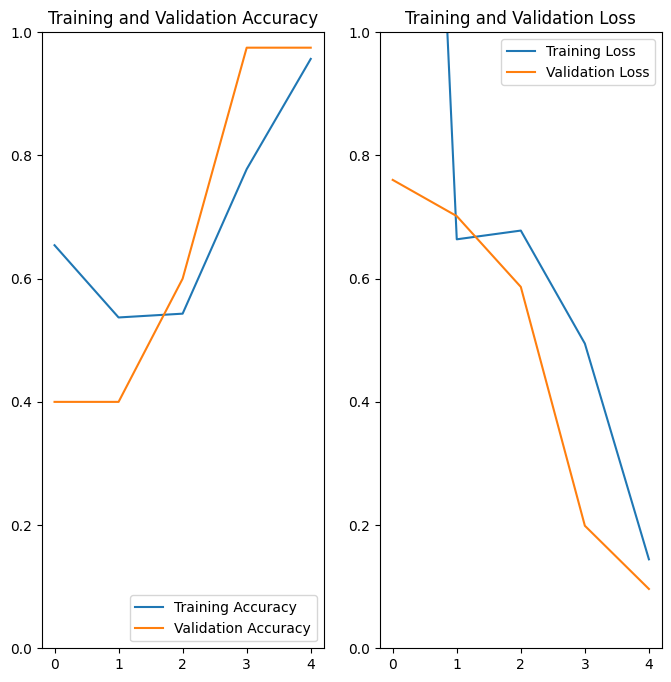

In [30]:
acc = ft_history_full.history['accuracy']
val_acc = ft_model.history.history['val_accuracy']

loss = ft_history_full.history['loss']
val_loss = ft_history_full.history['val_loss']

epochs_range = range(ft_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim(0,1)
plt.title('Training and Validation Loss')
plt.show()

We see that by fine tuning the pre-trained model we archieve a much better model already after very few epochs.

## References

[1] Image from: https://de.mathworks.com/discovery/convolutional-neural-network-matlab.html \
[2] Özgenel, Çağlar Fırat (2019), “Concrete Crack Images for Classification”, Mendeley Data, V2, doi: 10.17632/5y9wdsg2zt.2 \
[3] https://www.tensorflow.org/tutorials/load_data/images \
[4] https://www.tensorflow.org/tutorials/images/cnn \
[5] Image from: https://computersciencewiki.org/index.php/Max-pooling_/_Pooling \
[6] Image from: https://forum.knime.com/t/how-to-generate-accuracy-curve-by-epoch-to-detect-overfitting-with-training-validation-data/11916
